Expected Instrumental Noise from the test masses and the Optical Metrology Subsystem (OMS).
TODO: Make this into a python script and a function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, A1TDISens,E1TDISens, T1TDISens

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [2]:
# Tobs is the obvesrvation time in seconds. YRSID_SI is a siderial year = 31558149.763545603 seconds
Tobs = YRSID_SI / 2.

# This is the sampling interval, i.e., the time between two samples. The sampling rate is 1/dt
dt = 5.  # sec

# N is the number of samples in your original time-domain signal.
N = int(Tobs / dt)

# Convert Tobs into an integer number.
Tobs = N * dt

# This function returns the array of sample frequencies corresponding to the positive frequencies of the real-input Fast Fourier Transform (rFFT)
# The list goes from from zero to the Nyquist frequency, which is half the sampling rate: f[-1] = df/2 = 1/(2*dt)
# len(f) = floor(N/2) + 1 because the Nyquist frequency is included and the negative frequencies are not included in the rFFT
freq = np.fft.rfftfreq(N,dt)

# f[0] is 0.0. To avoid this, set f[0] to f[1]
freq[0] = freq[1]

# stochastic_params in sens_kwargs takes the time to add galactic foreground noise. It makes sense to put it as Tobs, which is the duration of observation.
# This is why N was calculated using Tobs and not written explicitly.
sens_kwargs = dict(stochastic_params=(Tobs,))

# Put the LISA sensitivity model in a list. See lisatools.sensitivity.get_stock_sensitivity_options for the list of available models.
# Does not work for FlatPSDFunction and it's slightly higher than the model for LISASens and CornishLISASens at low frequencies.
plot_labels = ['A1TDISens', 'E1TDISens', 'T1TDISens']

# SensitivityMatrix class gives a model of the LISA instrumental noises, given a frequency array, for every TDI channel in sens_model_array
sens_mat = SensitivityMatrix(freq, [globals()[label] for label in plot_labels], **sens_kwargs)

noises = noise_generation.generate_noise(N, dt, sens_mat, seed = 42, verification_plot=False, time_domain_plot=False, plot_lables=plot_labels)

In [49]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False), use_gpu=False)

m1 = 3e5
m2 = 2e5
# chi1z and chi2z are the dimensionless spins of the two black holes assumed to be aligned with the orbital angular momentum.
chi1z = 0.5
chi2z = 0.7
dist = 200 * 1e9 * PC_SI
phi_ref = 0.0
f_ref = 0.0
inc = np.pi/3.
beta = np.pi/4.  # ecliptic latitude
lam = np.pi/5.  # ecliptic longitude
psi = np.pi/6.  # polarization angle
t_ref = Tobs/2# - 60*60*24  # t_ref  (in the SSB reference frame) = merger time.

modes = [(2,2)]#, (2,1), (3,3), (3,2), (4,4), (4,3)]

wave_freq_domain = wave_gen(m1, m2, chi1z, chi2z,
                            dist, phi_ref, f_ref, inc, lam,
                            beta, psi, t_ref, 
                            freqs=freq, modes=modes, 
                            direct=False, fill=True, squeeze=True, length=1024)[0]

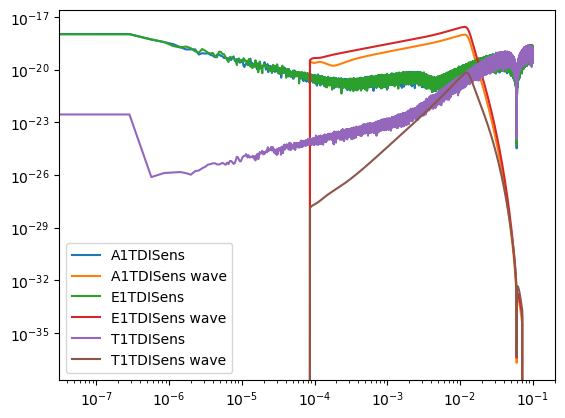

In [4]:
fout, pxxout = noise_generation.noise_time_to_freq_domain(noises, dt)
for i, let in enumerate(plot_labels):
    plt.loglog(fout[i], np.sqrt(pxxout[i]), label=let)
    plt.loglog(freq, np.abs(wave_freq_domain[i]), label=let+' wave')
plt.legend()
#plt.ylim(1e-24, 1e-17)

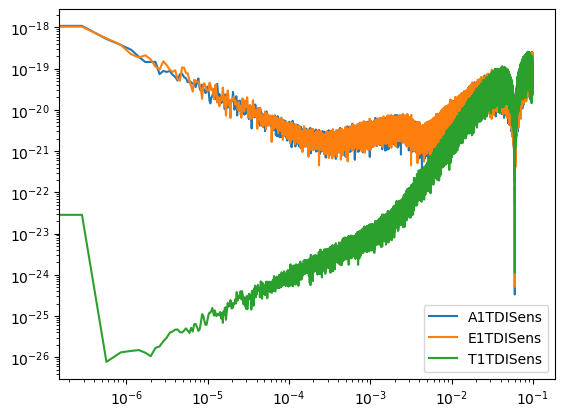

In [5]:
wave_time_domain = np.fft.irfft(wave_freq_domain, axis=-1)
wave_time_domain_with_noise = wave_time_domain + noises
fout_withnoise, pxxout_withnoise = noise_generation.noise_time_to_freq_domain(wave_time_domain_with_noise, dt)

for i, let in enumerate(plot_labels):
    plt.loglog(fout_withnoise[i], np.sqrt(pxxout_withnoise[i]), label=let)
plt.legend()

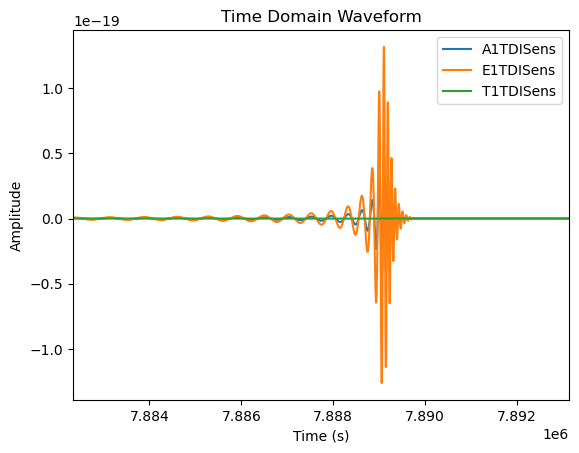

In [6]:
plt.figure()
for i in range(len(wave_time_domain)):
    plt.plot(np.arange(len(wave_time_domain[i])) * dt, wave_time_domain[i], label=plot_labels[i])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Waveform')
plt.xlim(t_ref - 60*60*2, t_ref + 60*60*1)
plt.legend()

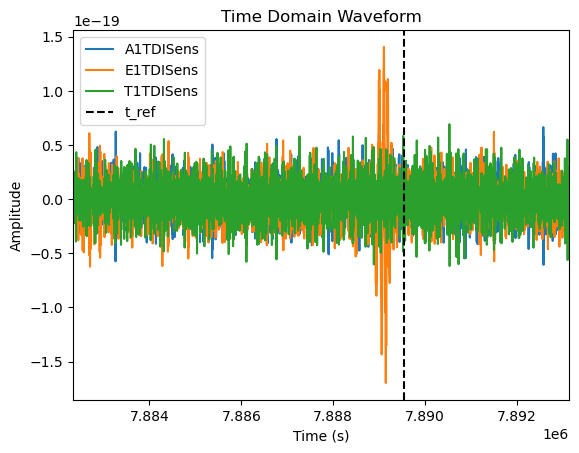

In [7]:

for i in range(len(wave_time_domain_with_noise)):
    plt.plot(np.arange(len(wave_time_domain_with_noise[i])) * dt, wave_time_domain_with_noise[i], label=plot_labels[i])

plt.axvline(t_ref, color='k', linestyle='--', label='t_ref')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Waveform')
plt.xlim(t_ref - 60*60*2, t_ref + 60*60*1)

plt.legend()


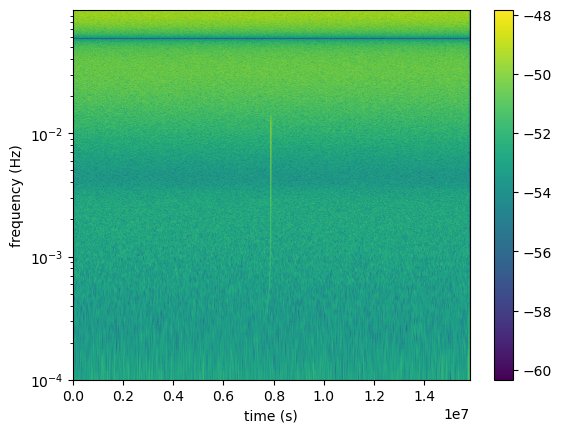

In [8]:
noise_generation.plot_spectrogram(wave_time_domain_with_noise[1], dt)

make a new script with the mcmc framework based on tut4 in the freq domain(check) tref, m1, m2 
switch to the sky loc later. 
time freq representation later.

In [15]:
wave_freq_domain_with_noise = np.fft.rfft(wave_time_domain_with_noise, axis=-1)

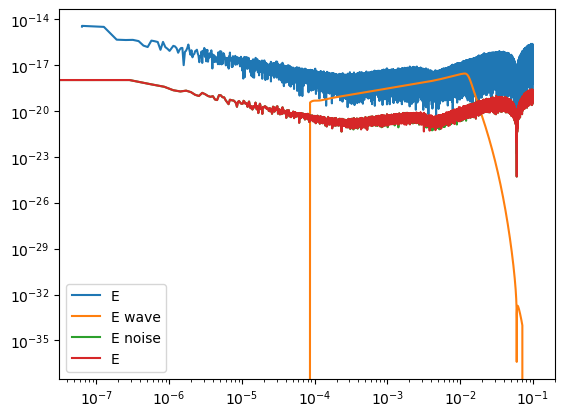

In [25]:
#for i, let in enumerate(plot_labels):
i=1
let='E'
plt.loglog(freq, np.abs(wave_freq_domain_with_noise[i]), label=let)
plt.loglog(freq, np.abs(wave_freq_domain[i]), label=let+' wave')
plt.loglog(fout[i], np.sqrt(pxxout[i]), label=let+' noise')
plt.loglog(fout_withnoise[i], np.sqrt(pxxout_withnoise[i]), label=let)
plt.legend()

In [27]:
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [50]:
def wrap(*args, **kwargs):
    return wave_gen(*args, **kwargs)[0]
data = DataResidualArray(wave_freq_domain, f_arr=freq)


sens_mat = AET1SensitivityMatrix(data.f_arr)


analysis = AnalysisContainer(data_res_arr=data, 
                             sens_mat=sens_mat, 
                             signal_gen=wrap)

analysis.snr()

35.98052426293915

In [51]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[8] = x[2]
    all_parameters[9] = x[3]

    all_parameters[np.array([2, 3, 4, 5, 6, 7, 10, 11])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
    )
    return ll

In [52]:
# clear (for internal clearing of answers)
 
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 1e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(-np.pi/2, np.pi/2),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1z,
    chi2z,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1z,
    chi2z,
    dist,
    phi_ref, 
    f_ref, 
    inc,
    psi,
    t_ref
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freq, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [53]:
from bbhx.likelihood import HeterodynedLikelihood

length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    wave_gen,
    freq,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

array([-5.66459285])

In [54]:
# clear (for internal clearing of answers)
 
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    all_parameters[8] = x[2]
    all_parameters[9] = x[3]
    all_parameters[np.array([2, 3, 4, 5, 6, 7, 10, 11])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [55]:
# clear (for internal clearing of answers)
 
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freq, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [56]:
start_params[0,0,0,:]

array([1.66490155e+06, 7.43777065e-01, 7.09436334e-01, 7.32778044e-01])

In [57]:
# clear (for internal clearing of answers)
 
injection_params_sub = np.array([m1 + m2, m2 / m1, lam, beta])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-1 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
#start_params[:, :, :, 3] = np.clip(start_params[:, :, :, 3], -np.pi/2, np.pi/2)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|██████████| 1000/1000 [02:32<00:00,  6.58it/s]


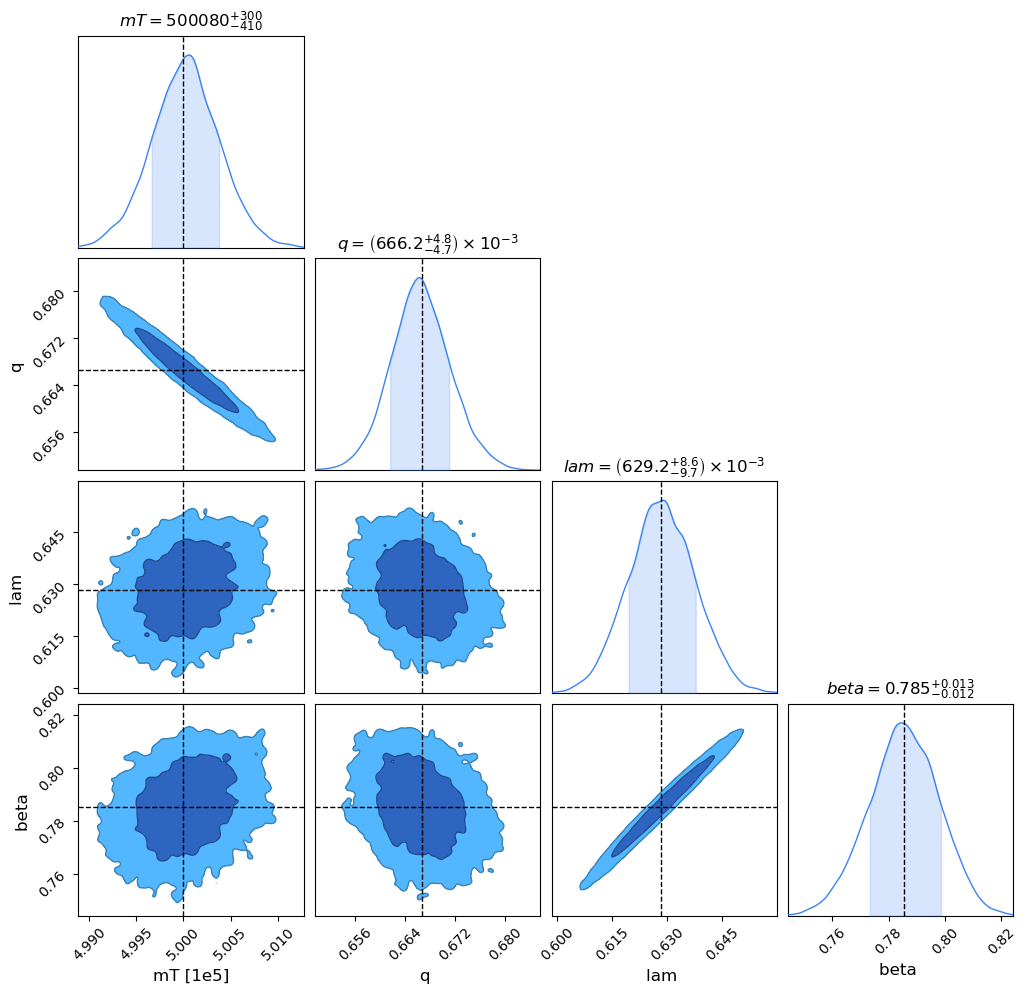

In [58]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "lam", "beta"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "lam": injection_params_sub[2], "beta": injection_params_sub[3]}))
fig = c.plotter.plot()